# C4.5 Decision Tree
The C4.5 algorithm is considered as **a landmark decision tree program 
that is probably the machine learning workhorse most widely used in practice 
to date** (*Ian H. Witten; Eibe Frank; Mark A. Hall (2011). 
"Data Mining: Practical machine learning tools and techniques, 3rd Edition". 
Morgan Kaufmann, San Francisco. p. 191.*). 

More information can be found
at https://en.wikipedia.org/wiki/C4.5_algorithm and 
http://www.saedsayad.com/decision_tree.htm

The output of C4.5 algorithm is a decision tree, while in most cases 
the tree is simply binary. For binary C4.5 
decision tree, each tree node has a `YES` or `NO` criterion.

In this notebook, assuming we already have a decision tree, we will see how 
to use the PL to accelerate the decision
making process.

## An example of imaginary decision tree

First of all, let's see the following 3-level (or 3-stage) decision tree:
![](data/imaginary_decision_tree.png)

If we study this (binary) decision tree, we will see for any data that
users provide, it has to consist of 4 fields: `weather`, `condition`, `day`, 
and `age`. Data has to be checked in each field to determine what the next hop
is; this is an essential step when searching the decision tree.

After searching this tree, we will arrive at several final decisions:
`work`, `home`, `video games`, `shopping`, and `movie`. Notice that although
the searching process can go through different paths, it may finally end up
with the same decision.

In this notebook, we will use the above decision tree as an example.

The criteria stored in the nodes can possibly change over time, and 
some values (like `age<50`) cannot be expressed nicely as a single 
value in a node, so let's define a mapping from the data to 
binary values.

| 4 fields ||
|---------------------------|
| Fields    |    Index    |
| Weather   | 00          |
| Condition | 01          |
| Day       | 10          |
| Age       | 11          |


| Weather (4 bits)||Condition (4 bits)|| Day (4 bits)     || Age (4 bits)     ||
|-------|---------|--------|---------|---------|--------|--------|---------|
| Value | Codes   |  Value | Codes   | Value   | Codes  | Value  | Codes   |
| sunny | 1000    | windy  | 0100    | weekday | 0010   | Age<20 | 0110    |
|       |         | rainy  | 1100    |         |        | Age<50 | 1110    |

| Decision (address) (3 bits)||
|---------------------------|
| Decision    |    Codes    |
| Work        |       000   |
| Home        |       001   |
| Video games |       010   |
| Shopping    |       011   |
| Work        |       100   |
| Movie       |       101   |
| Work        |       110   |
| Home        |       111   |

Notice it is probably an overkill for encoding the values using 4 bits.
Also, the encoding can be arbitrary as long as there is no conflict.
However, let's keep it as shown as an example.

In [1]:
DECISION_MAPPING = {
    0: 'Work',
    1: 'Home',
    2: 'Video games',
    3: 'Shopping',
    4: 'Work',
    5: 'Movie',
    6: 'Work',
    7: 'Home'
}

TREE_MAPPING = {
    0: {0: 8},
    1: {1: 4},
    2: {1: 12},
    3: {2: 2},
    4: {3: 6},
    5: {2: 2},
    6: {3: 14}
}

## Software Approach

### Step 1: A software-based decision tree

Based on these encoding table, we will design a simple software to search 
this tree. There are some subtleties:

1. There are lists to be kept: the field index, and the node values. They share common addresses.
2. For a given node stored at location `i`, its child nodes are kept in location `2i+1` and `2i+2`. This helps to eliminate the use of pointers.

The software decision tree is implemented in `decision_tree_sw.py`.

In [2]:
from pynq_decision_tree import SoftwareDecisionTree
decision_tree1 = SoftwareDecisionTree(num_fields=4, 
                                      num_bits_per_field=4, num_levels=3)

### Step 2: Populate the decision tree
Now we can instantiate the binary tree and load values into it.

In [3]:
for i in TREE_MAPPING:
    for j in TREE_MAPPING[i]:
        decision_tree1.load_sw(i, j, TREE_MAPPING[i][j])

### Step 3: Search the tree

Now we can prepare the data. The correct decision for the following data 
should be `movie`. 

The decision tree can work on a batch of data, 
but let's try a single data first.

In [4]:
example_data = {
    0: 6, # Weather != sunny
    1: 12, # Condition == rainy
    2: 1, # Day != weekday
    3: 14 # Age < 50 
}
data_batch = [example_data]

In [5]:
decision_tree1.prepare_sw(data_batch)
decision = decision_tree1.search_sw()[0]
DECISION_MAPPING[decision]

'Movie'

### Step 4: Measure the performance
We can also generate multiple data and time the processing. The following 
cell will take ~10 seconds.

In [6]:
from time import time
from random import randint
from copy import deepcopy

NUM_DATA = 10000

data_batch = [deepcopy(example_data) for _ in range(NUM_DATA)]
for data in data_batch:
    for j in data:
        data[j] = randint(0, 15)

t1 = time()
decision_tree1.prepare_sw(data_batch)
t2 = time()
decision_tree1.search_sw()
t3 = time()
sw_prep = t2-t1
sw_proc = t3-t2
sw_total = t3-t1

print('Preparation time for {} data is {} seconds.'.format(NUM_DATA, sw_prep))
print('Processing time for {} data is {} seconds.'.format(NUM_DATA, sw_proc))
print('Throughput: {0} packets/second'.format(NUM_DATA/sw_proc))

Preparation time for 10000 data is 3.04825758934021 seconds.
Processing time for 10000 data is 5.729687213897705 seconds.
Throughput: 1745.2959693409425 packets/second


## Hardware Approach

### Step 1: Design the hardware

We have constructed a decision tree overlay as follows.

![](data/decision_tree_3_stages.png)

The IP `binary_tree` is a pipelined version of the decision tree. Since
our decision tree has 3 levels, we deploy 3 stages. The IP is highly
parameterizable (`NUM_FIELDS`, `NUM_BITS_PER_FIELD`, `NUM_STAGES`, etc.).

To implement the example decision tree, we have used:
* Number of fields: 4
* Number of bits per field: 4
* Number of stages: 3

For AXI Lite interface of the binary tree, the control register has the 
following format:

| `slv_reg` number | bit index     | signals                                        |
|------------------|---------------|------------------------------------------------|
| 0                | 2:0           | `addr_i`, `load`, `reset`                      |
| 4,3,2,1          | 31:0          | node value of stage 0, stage 1, ...            |
| 8,7,6,5          | 31:0          | field index of stage 0, stage 1, ...           |
| 12,11,10,9       | 31:0          | RAM write address for stage 0, stage 1, ...    |

Note:

1. There are actually 16 slave registers deployed in the IP but we use only 12 of them.
2. `addr_i` should always be 0.
3. The early stages correspond to higher-order bits in a given slave register.
4. The slave register 0 (`slv_reg0`) will control the load and reset signals for the pipeline.

The AXI stream interfaces of the IP will be responsible for sending 
and receiving batch data from DMA.

### Step 2: Load the overlay
The corresponding Python wrapper has to be manually written, but it is
pretty straightforward (refer to `decision_tree_3_stages.py`).

In [7]:
from pynq_decision_tree import DecisionTree3StagesOverlay

overlay = DecisionTree3StagesOverlay(
    '/usr/local/lib/python3.6/dist-packages/pynq_decision_tree/'
    'overlays/decision_tree_3_stages/decision_tree_3_stages.bit')

The Python wrapper for the hardware decision tree is implemented in 
`decision_tree_hw.py`. Note that it takes in overlay as an argument (simply an implementation option).

In [8]:
from pynq_decision_tree import HardwareDecisionTree

decision_tree2 = HardwareDecisionTree(overlay, num_fields=4, 
                                      num_bits_per_field=4, num_levels=3)

### Step 3: Configure the pipeline
We can load tree data into the pipeline. We use the same `TREE_MAPPING` as
the software version.

In [9]:
for i in TREE_MAPPING:
    for j in TREE_MAPPING[i]:
        decision_tree2.load_hw(i, j, TREE_MAPPING[i][j])

### Step 4: Search the tree

Now we can prepare the data. Using the same `example_data` from the software 
version, we know the correct decision for the following data 
should be `movie`.

In [10]:
data_batch = [example_data]

In [11]:
decision_tree2.prepare_hw(data_batch)
decision = decision_tree2.search_hw()[0]
DECISION_MAPPING[decision]

'Movie'

### Step 5: Measure the performance

In [12]:
from time import time
from random import randint
from copy import deepcopy

NUM_DATA = 10000

data_batch = [deepcopy(example_data) for _ in range(NUM_DATA)]
for data in data_batch:
    for j in data:
        data[j] = randint(0, 15)

t1 = time()
decision_tree2.prepare_hw(data_batch)
t2 = time()
decision_tree2.search_hw()
t3 = time()
hw_prep = t2-t1
hw_proc = t3-t2

print('Preparation time for {} data is {} seconds.'.format(NUM_DATA, hw_prep))
print('Processing time for {} data is {} seconds.'.format(NUM_DATA, hw_proc))
print('Throughput: {0} packets/second'.format(NUM_DATA/hw_proc))

Preparation time for 10000 data is 2.8985660076141357 seconds.
Processing time for 10000 data is 0.0022809505462646484 seconds.
Throughput: 4384137.1380788125 packets/second


## Performance Comparison
Let's analyze the performance of our approaches.

Note that the preparation function for both software and hardware versions
are the same, so it took roughly the same amount of time to put data into
position. What hardware manages to reduce is the processing time.

In this notebook, we made assumption that the data came from the local machine.
In reality, the data can come from anywhere in a connected network. 
Hence we can assume data is always coming in a compact form (no need 
to call `prepare_sw()` or `prepare_hw()` in most cases).

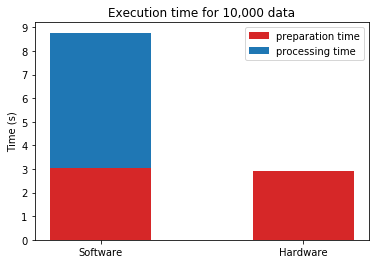

Speedup for processing time: 2511.97


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t_preparation = (sw_prep, hw_prep)
t_processing = (sw_proc, hw_proc)

ind = [0, 1]
width = 0.5

p1 = plt.bar(ind, t_preparation, width, color='#d62728')
p2 = plt.bar(ind, t_processing, width, bottom=t_preparation)

plt.ylabel('Time (s)')
plt.title('Execution time for 10,000 data')
plt.xticks(ind, ('Software', 'Hardware'))
plt.yticks(np.arange(0, 10, 1))
plt.legend((p1[0], p2[0]), ('preparation time', 'processing time'))

plt.show()

print('Speedup for processing time: {0:.2f}'.format(sw_proc/hw_proc))